# wave_energy dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import RegressionSkLearnWrapper
from sklearn.ensemble import GradientBoostingRegressor

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "wave_energy"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a gradient boosting regressor `GradientBoostingRegressor`. 

In [3]:
pred_model = RegressionSkLearnWrapper(GradientBoostingRegressor)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
#     InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.014479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Elapsed time LeaveOneOut(): 0:00:14.744314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.96it/s]


Elapsed time DVRL(rl_epochs=2000): 0:01:40.614042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13667.17it/s]


Elapsed time KNNShapley(k_neighbors=50): 0:00:00.013455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.47it/s]


Elapsed time DataOob(num_models=1000): 0:01:58.127623


Elapsed time LavaEvaluator(): 0:00:00.024313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 102.77it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:02.923188
CPU times: user 3min 53s, sys: 478 ms, total: 3min 54s
Wall time: 3min 56s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/wave_energy_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DVRL(rl_epochs=2000),0.185185
DataOob(num_models=1000),0.160000
KNNShapley(k_neighbors=50),0.000000
LavaEvaluator(),0.000000
LeaveOneOut(),0.187500
RandomEvaluator(),0.150943
RobustVolumeShapley(mc_epochs=300),0.157895


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

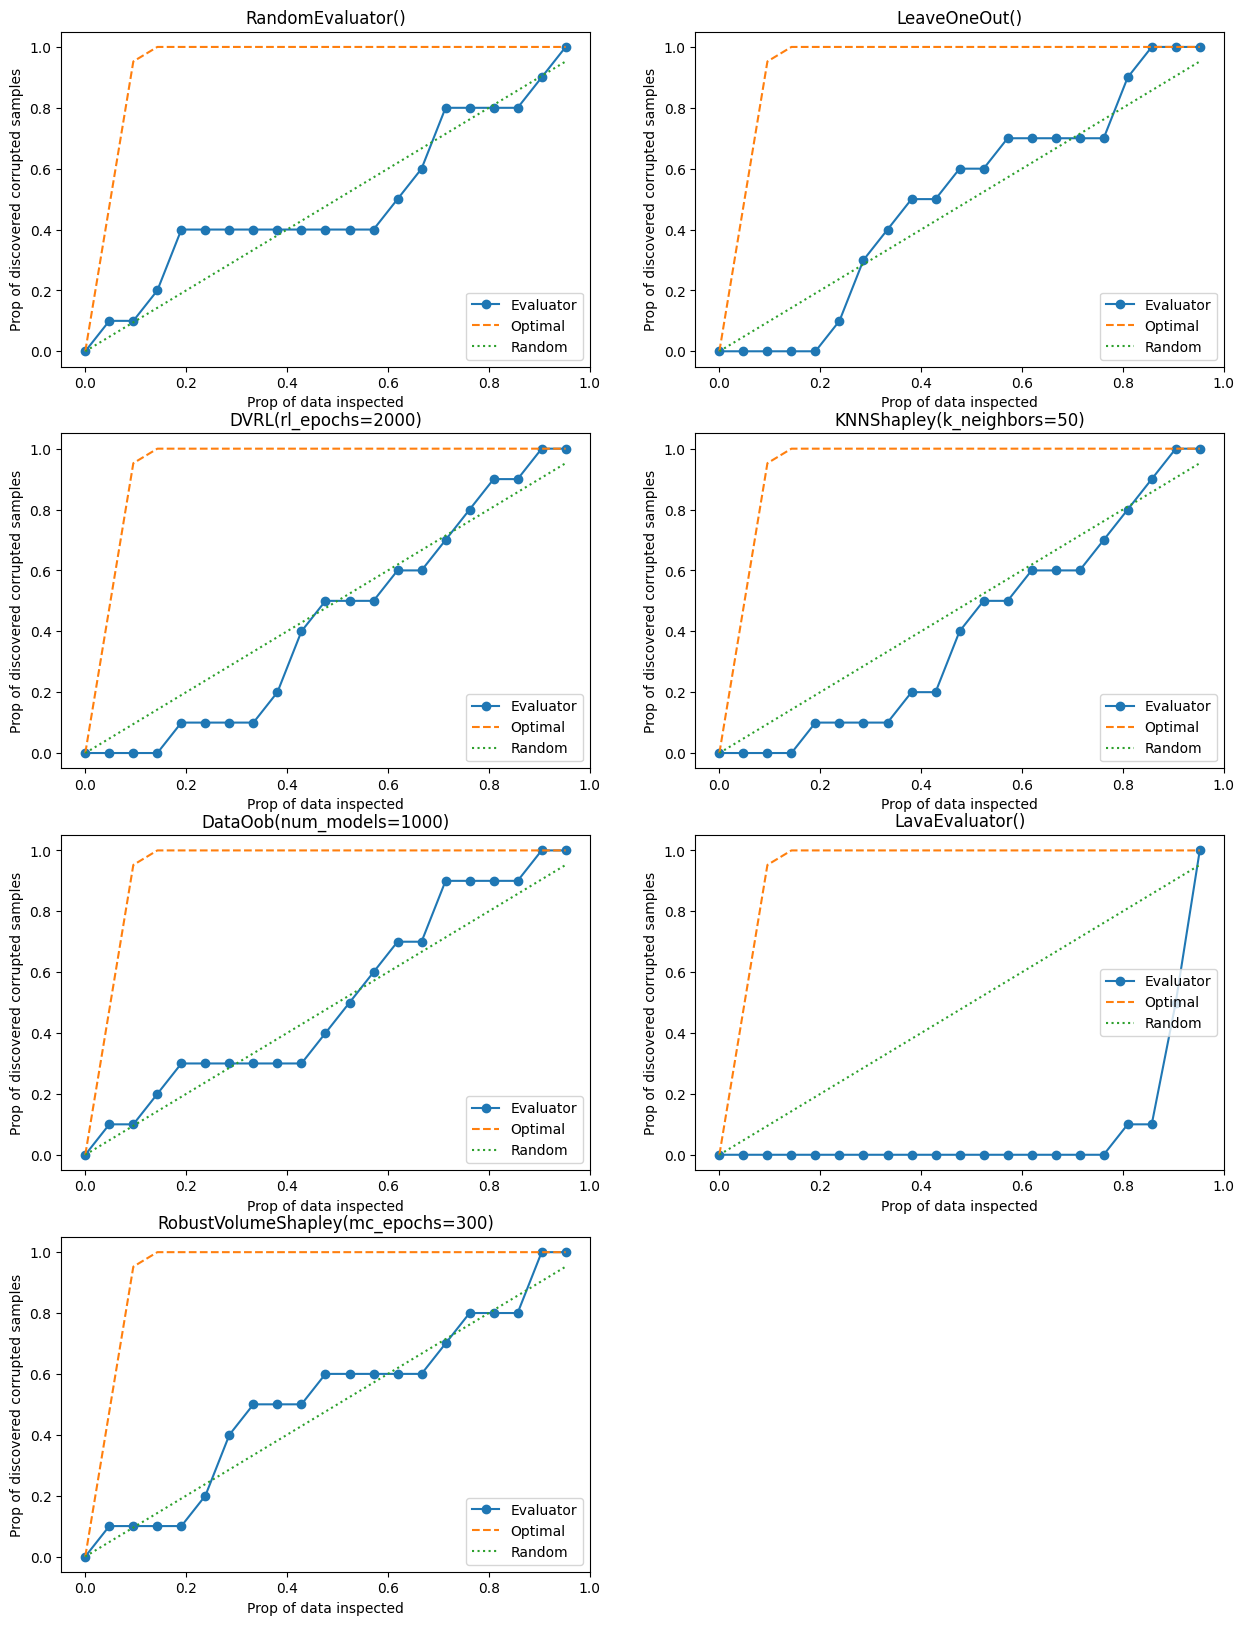

In [9]:
fig = plt.figure(figsize=(15, 20))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

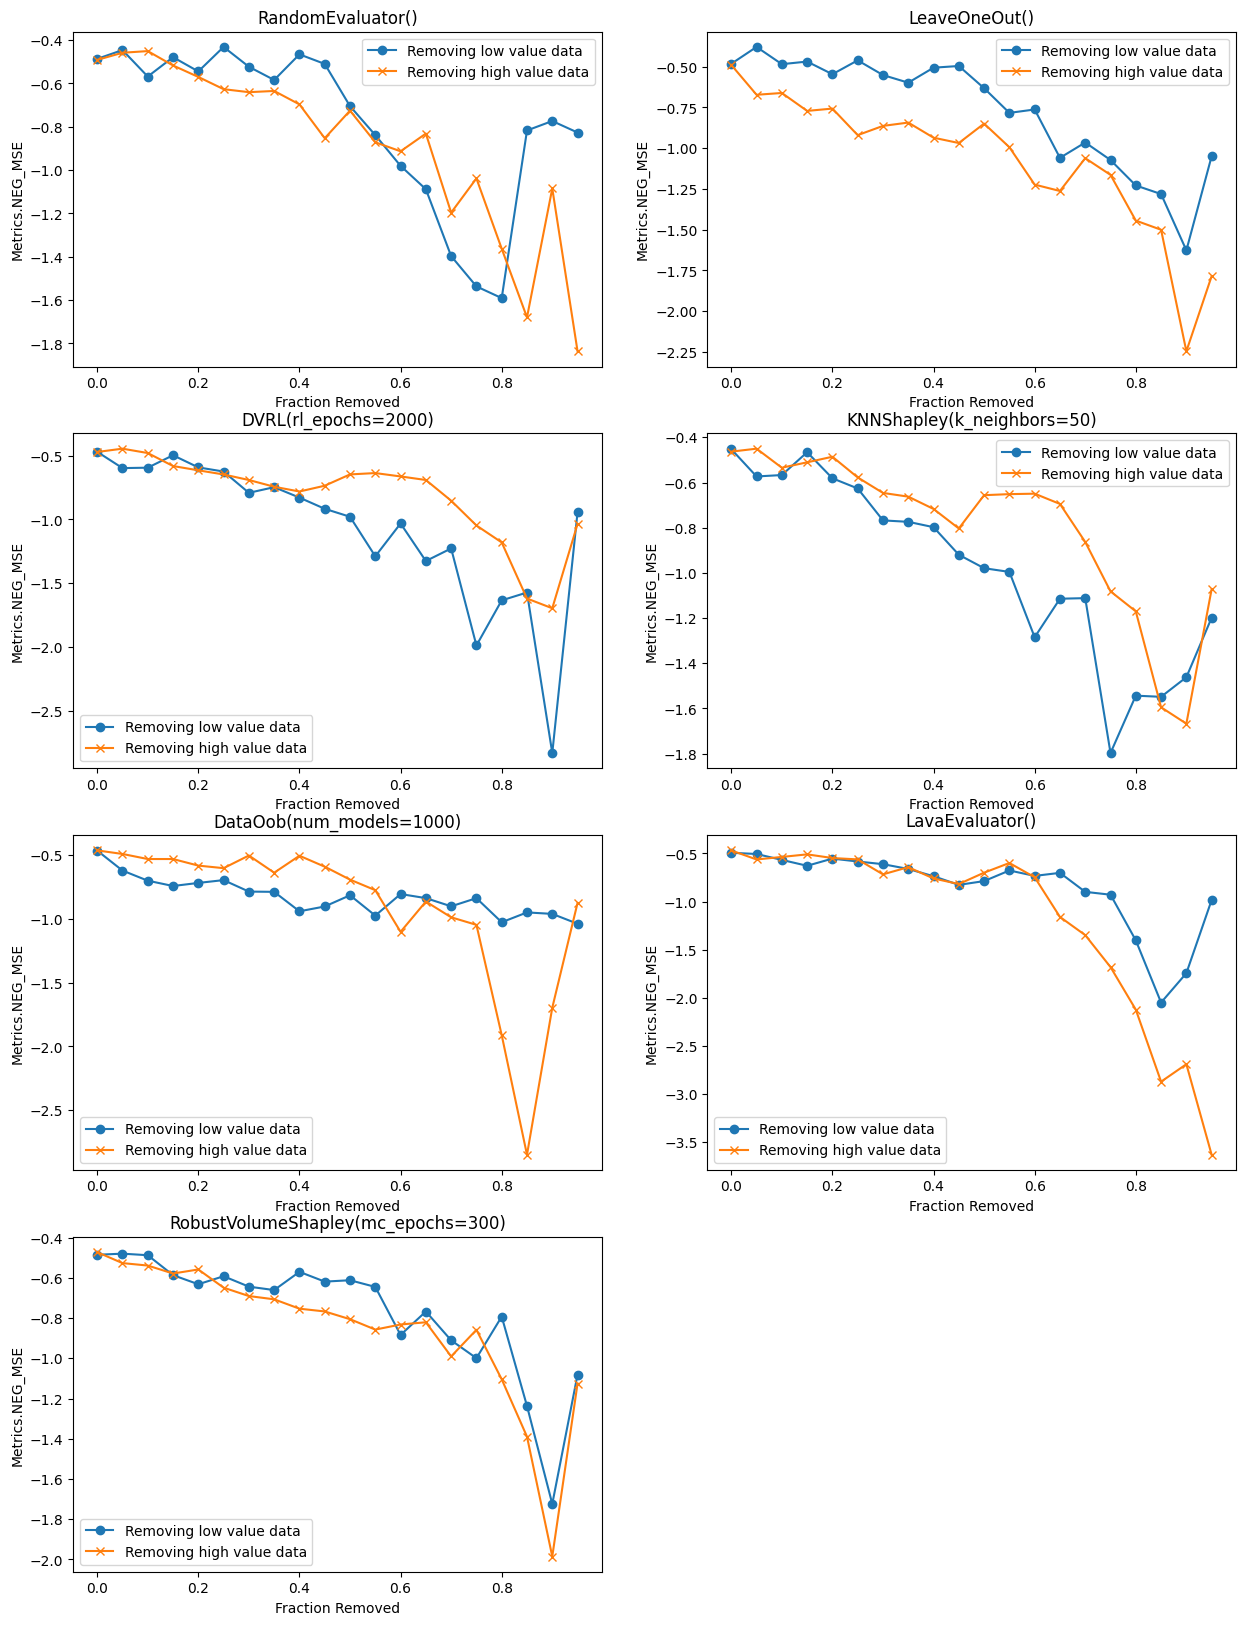

In [10]:
fig = plt.figure(figsize=(15, 20))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.48643,-0.491146,0.0
RandomEvaluator(),-0.445839,-0.458247,0.05
RandomEvaluator(),-0.568051,-0.450607,0.1
RandomEvaluator(),-0.478734,-0.516962,0.15
RandomEvaluator(),-0.544468,-0.569876,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),-0.999103,-0.858089,0.75
RobustVolumeShapley(mc_epochs=300),-0.792493,-1.104043,0.8
RobustVolumeShapley(mc_epochs=300),-1.236874,-1.389323,0.85
RobustVolumeShapley(mc_epochs=300),-1.723897,-1.985212,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),27457,0.238011
RandomEvaluator(),29444,0.81047
RandomEvaluator(),15858,0.523234
RandomEvaluator(),42262,0.183904
RandomEvaluator(),30998,0.31187
...,...,...
RobustVolumeShapley(mc_epochs=300),35775,0.0
RobustVolumeShapley(mc_epochs=300),50898,0.0
RobustVolumeShapley(mc_epochs=300),22574,0.0
RobustVolumeShapley(mc_epochs=300),30447,0.0
